# Test Code

### IMPORTS

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, int32, pad

In [10]:
# Description:
#
# Read given matrix to PGM file
#
# @param[1]: Filename. It is name of PGM file that wants to read.
#
# @return[1]: Image Data. The values of image pixels.
# @return[2]: Magic Number. Magic number is identifies the file type. PGM file type is P5. Default define is P5.
# @return[3]: Width. Width value of the image.
# @return[4]: Height. Height value of the image.
# @return[5]: Resolution. The value of maximum pixel value.
#
def pgmread(filename):
    # Open pgm file with binary reading
    f = open(filename,'rb')
    
    # Read all the pgm file
    imageBinary = f.read()

    # Header struct
    # P5\n (or P2 / Magic Number)
    # 512 512\n (Width and height value, blank space between these number)
    # 256\n (Resolution value)
    # Data (Binary format)
    
    # Define variables for header reader while loop
    lineCounter = 0
    cursorIndex = 0
    buffer = '' # Reading buffer
    width = '' # Height info
    height = '' # Width info

    # Reading the header struct of pgm file
    # Skip all comments
    # Just read magic number, width, height and resolution
    # Boundry for line number, because of header struct consist of three lines
    while lineCounter < 3:
        # Read binary till encounter the line feed
        # It means, it read one line
        if (chr(imageBinary[cursorIndex]) == '\n'):
            if(lineCounter == 2): # Resolution info
                resolution = buffer
                lineCounter = lineCounter + 1 # Increase line counter
                buffer = '' # Clean buffer
            if (lineCounter == 1): # Width and height info
                [width,height] = buffer.split(' ') # Split buffer to take width and height infos
                lineCounter = lineCounter + 1
                buffer = ''
            if (lineCounter == 0): # Magic num info
                magicNum = buffer
                lineCounter = lineCounter + 1
                buffer = ''
            cursorIndex = cursorIndex + 1
        # Comment skipper block
        if (chr(imageBinary[cursorIndex]) == '#'):
            comment_check = True
            # Skip bytes till encounter line feed and there is no more comment
            while comment_check:
                if (chr(imageBinary[cursorIndex]) == '\n') and (chr(imageBinary[cursorIndex+1]) != '#'):comment_check = False
                cursorIndex = cursorIndex + 1
            buffer = ''
        buffer = buffer + chr(imageBinary[cursorIndex]) # Add bytes to buffer
        cursorIndex = cursorIndex + 1 # Increase cursor index to take next byte to buffer

    # Add rest of the pgm bytes to data vector
    imageData = imageBinary[cursorIndex-1:]
    
    # Return the result
    return (imageData,magicNum,int(width),int(height),int(resolution))

In [11]:
# Description:
#
# The function that apply the given filter to given one pixel for using in other functions
#
# @param[1]: Image. Image matrix that wants to apply filter
# @param[2]: Filter. Filter that wants to apply
# @param[3]: Pad number. Number of added pad frame to image matrix
# @param[4]: Height index. Height value of the pixel that wants to apply filter
# @param[5]: Width index. Width value of the pixel that wants to apply filter
#
# @return: Pixel value. Pixel value that applied filter.
def filterApplicator(image,filterName,filterLength,heightIndex,widthIndex):
    padNumber = 0
    
    filter = np.zeros((filterLength*filterLength))
    if(filterName == 'lowpass'):
        filter = np.ones((filterLength,filterLength))
        padNumber = int(filterLength/2)
    elif(filterName == 'median'):
        filter = np.zeros((filterLength*filterLength))
        padNumber = int(filterLength/2)
        medianIndex = 0
        
        for imageHeightIndex in range(heightIndex-padNumber,heightIndex-padNumber+filterLength):
            for imageWidthIndex in range(widthIndex-padNumber,widthIndex-padNumber+filterLength):
                filter[medianIndex] = image[imageHeightIndex][imageWidthIndex]
                medianIndex = medianIndex + 1
                imageWidthIndex = imageWidthIndex + 1
            imageWidthIndex = widthIndex-padNumber
            imageHeightIndex = imageHeightIndex + 1
    
        medianVector = np.sort(filter)
    
        medianValueIndex = int((filterLength*filterLength)/2) + 1
        medianValue = medianVector[medianValueIndex]
        return medianValue
    elif(filterName == 'laplace'):
        filter = [[0,-1,0],[-1,4,-1],[0,-1,0]]
        padNumber = int(3/2)
    elif(filterName == 'gauss'):
        filter = [[1,2,1],[2,4,2],[1,2,1]]
        padNumber = int(3/2)
    
    # Initial definition of index values for for loop
    pixelValue = 0
    filterHeightIndex = 0 
    filterWidthIndex = 0
    imageHeightIndex = heightIndex-padNumber # Height start index of image matrix
    imageWidthIndex = widthIndex-padNumber # Width start index of image matrix
    
    # for loop that apply filter to given pixel
    for filterHeightIndex in range(len(filter)):
        for filterWidthIndex in range(len(filter)):
            pixelValue = pixelValue + (image[imageHeightIndex][imageWidthIndex]*filter[filterHeightIndex][filterWidthIndex])
            filterWidthIndex = filterWidthIndex + 1
            imageWidthIndex = imageWidthIndex + 1
        imageWidthIndex = widthIndex-padNumber # Reset the width start index of the image matrix
        filterHeightIndex = filterHeightIndex + 1
        imageHeightIndex = imageHeightIndex + 1
    
    # Variable definition for normalizing the pixel value
    filterValueSum = 0
    
    # Summing the filter values for pixel normalization
    for i in range(len(filter)):
        for j in range(len(filter)):
            filterValueSum = filterValueSum + filter[i][j]
    pixelValue = pixelValue / filterValueSum
    
    return pixelValue # Return the pixel value

In [12]:
# Description:
#
# The function that smooth the given image by given filter
#
# @param[1]: Image. Image matrix that wants to smooth
# @param[2]: Filter. Filter that wants to apply
# @param[3]: Pad number. Number of added pad frame to image matrix
# @param[4]: Height index. Height value of the pixel that wants to apply filter
# @param[5]: Width index. Width value of the pixel that wants to apply filter
#
# @return: Matrix. The matrix that consist of smoothed pixel values of the given image
def imageFilter(matrix,filter,filterLength,height,width):
    padNumber = int(filterLength/2)

    imageHeightIndex = padNumber
    imageWidthIndex = padNumber
    
    # Add pad
    paddedMatrix= np.pad(matrix,padNumber,mode='constant')
    
    # Create blank matrix for image smoothing
    smoothedImage = np.zeros((height,width))

    # for loop that smooth the given image
    for heightIndex in range(height):
        for widthIndex in range(width):
            smoothedImage[heightIndex][widthIndex] = filterApplicator(paddedMatrix,filter,filterLength,imageHeightIndex,imageWidthIndex)
            imageWidthIndex = imageWidthIndex + 1
        widthIndex = 0
        imageWidthIndex = widthIndex + padNumber
        imageHeightIndex = imageHeightIndex + 1
    return smoothedImage # Return the matrix

In [13]:
# Description:
#
# The function that smooth the given image by given filter
#
# @param[1]: Image. Image matrix that wants to smooth
# @param[2]: Filter. Filter that wants to apply
# @param[3]: Pad number. Number of added pad frame to image matrix
# @param[4]: Height index. Height value of the pixel that wants to apply filter
# @param[5]: Width index. Width value of the pixel that wants to apply filter
#
# @return: Matrix. The matrix that consist of smoothed pixel values of the given image
def imageSmoother(matrix,filter,filterLength,height,width):
    padNumber = int(filterLength/2)

    imageHeightIndex = padNumber
    imageWidthIndex = padNumber
    
    # Add pad
    paddedMatrix= np.pad(matrix,padNumber,mode='constant')
    
    # Create blank matrix for image smoothing
    smoothedImage = np.zeros((height,width))

    # for loop that smooth the given image
    for heightIndex in range(height):
        for widthIndex in range(width):
            smoothedImage[heightIndex][widthIndex] = filterApplicator(paddedMatrix,'lowpass',filterLength,imageHeightIndex,imageWidthIndex)
            imageWidthIndex = imageWidthIndex + 1
        widthIndex = 0
        imageWidthIndex = widthIndex + padNumber
        imageHeightIndex = imageHeightIndex + 1
    return smoothedImage # Return the matrix

In [14]:
def imageMedian(matrix,medianLength,height,width):
    padNumber = int(medianLength/2)

    # Add pad
    paddedMatrix= np.pad(matrix,padNumber,mode='constant')
    
    imageHeightIndex = padNumber
    imageWidthIndex = padNumber
    
    imageMedian = np.zeros((height,width))

    for heightIndex in range(height):
        for widthIndex in range(width):
            imageMedian[heightIndex][widthIndex] = filterApplicator(paddedMatrix,'median',medianLength,imageHeightIndex,imageWidthIndex)
            imageWidthIndex = imageWidthIndex + 1
        widthIndex = 0
        imageWidthIndex = widthIndex + padNumber
        imageHeightIndex = imageHeightIndex + 1
    return imageMedian

# Test Code

Magic Num: P5
Width: 455
Height: 440
Resolution: 255


Image Matrix: 

[[246   0 249 ... 248 248 248]
 [247 249 250 ... 245 245 245]
 [  0 250 251 ... 243 243 255]
 ...
 [233 233 232 ... 156 150 165]
 [255 233 232 ... 157 149 165]
 [233 233 232 ... 161 150 162]]




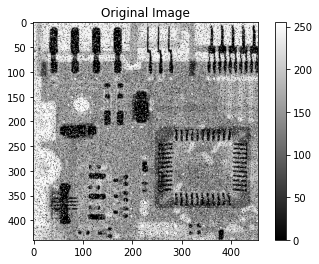

In [15]:
# Add image file
[image,magicNum,width,height,resolution] = pgmread('circuit.pgm')

# Image infos
print('Magic Num:',magicNum)
print('Width:',width)
print('Height:',height)
print('Resolution:',resolution)
print('\n')

# Convert image string to byte matrix
image = bytearray(image)    
image = list(image)
image = np.array(image)
image = np.reshape(image,(height,width))

# Image byte matrix info
print('Image Matrix: \n')
print(image)
print('\n')

# Show image
plt.figure()
plt.title('Original Image')
plt.imshow(image, cmap="gray")
plt.colorbar()

Median Filter of Image:
[[  0. 247. 249. ... 245. 245. 245.]
 [246. 249. 250. ... 245. 248. 245.]
 [247. 249. 250. ... 245. 245. 245.]
 ...
 [233. 233. 232. ... 158. 158. 158.]
 [233. 233. 232. ... 161. 161. 150.]
 [233. 233. 232. ... 157. 157. 149.]]


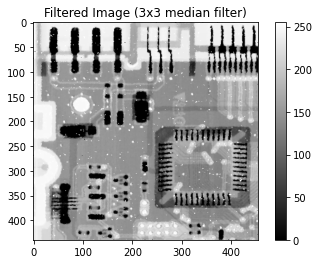

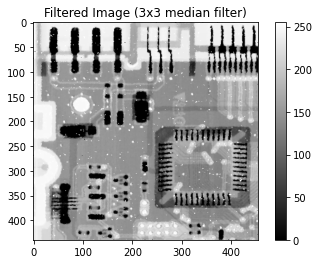

In [17]:
# APPLY MEDIAN FILTER

# Call imageMedian function to filter image
medianImage = imageFilter(image,'median',3,height,width)
medianImage2 = imageMedian(image,3,height,width)

# Show filtered image matrix
print('Median Filter of Image:')
print(medianImage)

# Show image
plt.figure()
plt.title('Filtered Image (3x3 median filter)')
plt.imshow(medianImage, cmap="gray")
plt.colorbar()

# Show image
plt.figure()
plt.title('Filtered Image (3x3 median filter)')
plt.imshow(medianImage2, cmap="gray")
plt.colorbar()

Magic Num: P5
Width: 500
Height: 500
Resolution: 255


Image Matrix: 

[[229 229 229 ... 229 255 255]
 [229 229 229 ... 229 229 229]
 [229 229 229 ... 229 229 229]
 ...
 [229 229 229 ... 229 229 229]
 [229 229 229 ... 229 229 229]
 [229 229 229 ... 229 229 255]]




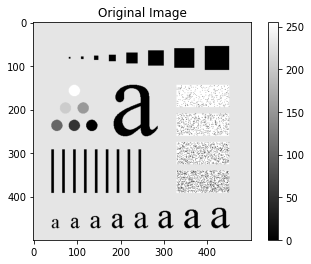

In [10]:
# Add image file
[image,magicNum,width,height,resolution] = pgmread('test_pattern.pgm')

# Image infos
print('Magic Num:',magicNum)
print('Width:',width)
print('Height:',height)
print('Resolution:',resolution)
print('\n')

# Convert image string to byte matrix
image = bytearray(image)    
image = list(image)
image = np.array(image)
image = np.reshape(image,(height,width))

# Image byte matrix info
print('Image Matrix: \n')
print(image)
print('\n')

# Show image
plt.figure()
plt.title('Original Image')
plt.imshow(image, cmap="gray")
plt.colorbar()

Smoothed Image:
[[ 82.44 109.92 137.4  ... 139.48 112.    84.52]
 [109.92 146.56 183.2  ... 185.28 148.64 112.  ]
 [137.4  183.2  229.   ... 231.08 185.28 139.48]
 ...
 [137.4  183.2  229.   ... 230.04 184.24 138.44]
 [109.92 146.56 183.2  ... 184.24 147.6  110.96]
 [ 82.44 109.92 137.4  ... 138.44 110.96  83.48]]


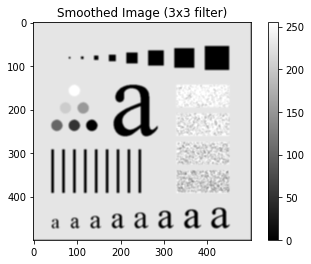

In [14]:
# Call imageSmoother function to smooth image
smoothedImage = imageSmoother(image,'lowpass',3,height,width)

# Show smoothed image matrix
print('Smoothed Image:')
print(smoothedImage)

# Show image
plt.figure()
plt.title('Smoothed Image (3x3 filter)')
plt.imshow(smoothedImage, cmap="gray")
plt.colorbar()